<a href="https://colab.research.google.com/github/alvincharles45/alvincharles45.github.io/blob/main/notebooks/starter_bikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks


In [36]:
df = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv")
df_dec = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes_december.csv")


In [37]:
# Parse date
df["dteday"] = pd.to_datetime(df["dteday"])
df_dec["dteday"] = pd.to_datetime(df_dec["dteday"])

# Target: total bikes
df["total_bikes"] = df["casual"] + df["registered"]

# Create date parts + cyclical encodings for BOTH datasets
for frame in [df, df_dec]:
    # Calendar parts
    frame["dayofweek"] = frame["dteday"].dt.dayofweek  # 0=Mon,...,6=Sun
    frame["month"] = frame["dteday"].dt.month          # 1–12

    # Cyclical for hour of day (0–23)
    frame["hr_sin"] = np.sin(2 * np.pi * frame["hr"] / 24)
    frame["hr_cos"] = np.cos(2 * np.pi * frame["hr"] / 24)

    # Cyclical for day of week (0–6)
    frame["dow_sin"] = np.sin(2 * np.pi * frame["dayofweek"] / 7)
    frame["dow_cos"] = np.cos(2 * np.pi * frame["dayofweek"] / 7)

    # Cyclical for month (1–12 → shift to 0–11)
    frame["month_sin"] = np.sin(2 * np.pi * (frame["month"] - 1) / 12)
    frame["month_cos"] = np.cos(2 * np.pi * (frame["month"] - 1) / 12)

# Base features:
# numeric (incl. cyclical) + small categoricals (season, weathersit)
base_features = [
    "holiday",
    "workingday",
    "temp_c",
    "feels_like_c",
    "hum",
    "windspeed",
    "hr_sin", "hr_cos",
    "dow_sin", "dow_cos",
    "month_sin", "month_cos",
    "season",
    "weathersit"
]


In [38]:
cat_cols = ["season", "weathersit"]
num_cols = [
    "holiday",
    "workingday",
    "temp_c",
    "feels_like_c",
    "hum",
    "windspeed",
    "hr_sin", "hr_cos",
    "dow_sin", "dow_cos",
    "month_sin", "month_cos"
]

# Training features/target
X = df[base_features].copy()
y = df["total_bikes"].values

# One-hot encode season & weathersit
X = pd.get_dummies(X, columns=cat_cols, drop_first=False)

# Save final column layout
feature_cols_final = X.columns.tolist()

# December features with same structure
X_dec = df_dec[base_features].copy()
X_dec = pd.get_dummies(X_dec, columns=cat_cols, drop_first=False)
X_dec = X_dec.reindex(columns=feature_cols_final, fill_value=0)


In [40]:
# Sort df by date and hour to respect time order
df_sorted_idx = df.sort_values(["dteday", "hr"]).index

# Apply this order to X_scaled and y
X_sorted = X_scaled[df_sorted_idx]
y_sorted = y[df_sorted_idx]

# 80% train, 20% validation
train_size = int(len(df) * 0.8)

X_train = X_sorted[:train_size]
y_train = y_sorted[:train_size]

X_val = X_sorted[train_size:]
y_val = y_sorted[train_size:]

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)


Train shape: (89980, 20)
Validation shape: (22495, 20)


In [41]:
input_dim = X_train.shape[1]

model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(512, activation="swish"),
    layers.Dense(512, activation="swish"),
    layers.Dense(256, activation="swish"),
    layers.Dense(128, activation="swish"),
    layers.Dense(1, activation="softplus")  # regression output
])

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
    loss="mse",
    metrics=["mae"]
)

model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 512)            │        10,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 437,761 (1.67 MB)

 Trainable params: 437,761 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5
)


In [43]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/100
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.1969 - mae: 0.3081 - val_loss: 0.0613 - val_mae: 0.2009 - learning_rate: 0.0010
Epoch 2/100
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0662 - mae: 0.1891 - val_loss: 0.0529 - val_mae: 0.1866 - learning_rate: 0.0010
Epoch 3/100
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0623 - mae: 0.1836 - val_loss: 0.0529 - val_mae: 0.1882 - learning_rate: 0.0010
Epoch 4/100
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0596 - mae: 0.1781 - val_loss: 0.0813 - val_mae: 0.2457 - learning_rate: 0.0010
Epoch 5/100
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0568 - mae: 0.1745 - val_loss: 0.0563 - val_mae: 0.1939 - learning_rate: 0.0010
Epoch 6/100
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0535 - mae: 0.1687 - val_loss: 0.0650 - val_mae: 0.2125 - learning_rate: 5.0000e-04
Epoch 7/100
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0532 - mae: 0.1683 - val_loss: 0.0566 - val_mae: 0.1946 - lea

In [44]:
# Predict on validation set
y_val_pred = model.predict(X_val).flatten()

# Compute MSE and MAE from Keras
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)

# RMSE
rmse = np.sqrt(val_loss)

# R-squared
ss_res = np.sum((y_val - y_val_pred) ** 2)
ss_tot = np.sum((y_val - np.mean(y_val)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f"Validation MSE : {val_loss:.2f}")
print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation MAE : {val_mae:.2f}")
print(f"Validation R²  : {r2:.4f}")



703/703 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation MSE : 0.05
Validation RMSE: 0.22
Validation MAE : 0.18
Validation R²  : 0.8611


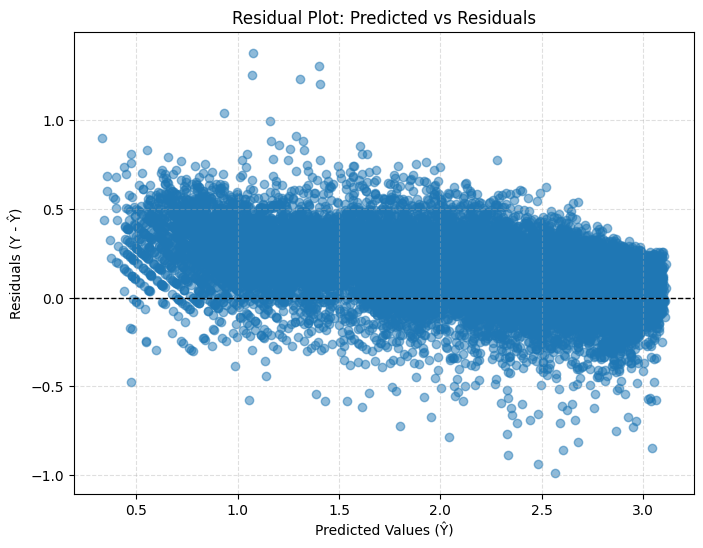

In [46]:
import matplotlib.pyplot as plt

# Residuals
residuals = y_val - y_val_pred

plt.figure(figsize=(8,6))
plt.scatter(y_val_pred, residuals, alpha=0.5)

# Reference line at 0
plt.axhline(0, color="black", linestyle="--", linewidth=1)

plt.xlabel("Predicted Values (Ŷ)")
plt.ylabel("Residuals (Y - Ŷ)")
plt.title("Residual Plot: Predicted vs Residuals")
plt.grid(True, linestyle="--", alpha=0.4)

plt.show()


In [49]:
y_val_pred_original = (10 ** y_val_pred) - 1

y_val_pred_original

array([ 424.61682,  598.24585, 1081.9415 , ...,  227.90002,  168.65134,
         81.66906], dtype=float32)

In [50]:
# Predict (model outputs log10(total_bikes + 1))
y_dec_pred_log = model.predict(X_dec_scaled).flatten()

# Undo the log transformation: original = (10^log) - 1
y_dec_pred = (10 ** y_dec_pred_log) - 1

# Prevent any negative float noise
y_dec_pred = np.clip(y_dec_pred, 0, None)

# Round to integer bike counts
y_dec_pred = np.round(y_dec_pred).astype(int)

# Save to CSV (use the column name your instructor expects)
preds_df = pd.DataFrame({
    "total_bikes": y_dec_pred
})

preds_df.to_csv("bikes_december_predictions.csv", index=False)

print("Saved predictions to bikes_december_predictions.csv")


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Saved predictions to bikes_december_predictions.csv
